<a href="https://colab.research.google.com/github/NathanielRose/eeg-294/blob/master/Test_Notebook_Vilde_RNN_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Test Notebook Vilde: RNN**

Trying to reproduce RNN model example.

# **Setup**

In [28]:
!pip install git+git://github.com/gumpy-bci/gumpy.git

  Cloning git://github.com/gumpy-bci/gumpy.git to /tmp/pip-req-build-bwn1oag3
  Running command git clone -q git://github.com/gumpy-bci/gumpy.git /tmp/pip-req-build-bwn1oag3
  Created wheel for gumpy: filename=gumpy-0.5.0-cp36-none-any.whl size=32999 sha256=a15ddc9ba52ae5dcc2fcd33f11e5d41388e1cfb8b511260bd24ce9dc89bdcc7c
  Stored in directory: /tmp/pip-ephem-wheel-cache-xnblmb_w/wheels/cf/ee/4d/dfa04a0d04ffb1ca36f436f3fef4817e9e23bfec03dd772913
Successfully built gumpy


In [29]:
!git clone https://github.com/NathanielRose/eeg-294.git

fatal: destination path 'eeg-294' already exists and is not an empty directory.


In [30]:
%reset
%matplotlib inline

from __future__ import print_function
import os; os.environ["THEANO_FLAGS"] = "device=gpu0"
import os.path
from datetime import datetime
import sys

import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import pandas as pd

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [0]:
sys.path.append('gumpy/gumpy/')
import gumpy

sys.path.append('eeg-294/gumpy-deeplearning')
import models

sys.path.append('eeg-294/gumpy-deeplearning/models/')
import utils

In [0]:
# just copied from LSTM/RCNN --> must be specified

##Setup parameters##
DEBUG = True
CLASS_COUNT = 2
DROPOUT = 0.2   # dropout rate in float

# parameters for filtering data
FS = 250
LOWCUT = 2
HIGHCUT = 60
ANTI_DRIFT = 0.5
CUTOFF = 50.0 # freq to be removed from signal (Hz) for notch filter
Q = 30.0  # quality factor for notch filter 
W0 = CUTOFF/(FS/2)
AXIS = 0

#set random seed
SEED = 42
KFOLD = 5

In [33]:
# Load raw data
%%bash
%%capture 

export fileid=1DS64UOrt9wzswke5wiFtat94-s1YcRmb
export filename=grazdata.zip


wget --save-cookies cookies.txt 'https://docs.google.com/uc?export=download&id='$fileid -O- \
     | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1/p' > confirm.txt

wget --load-cookies cookies.txt -O $filename \
     'https://docs.google.com/uc?export=download&id='$fileid'&confirm='$(<confirm.txt)

bash: line 1: fg: no job control
--2019-11-26 05:54:35--  https://docs.google.com/uc?export=download&id=1DS64UOrt9wzswke5wiFtat94-s1YcRmb
Resolving docs.google.com (docs.google.com)... 108.177.119.100, 108.177.119.139, 108.177.119.138, ...
Connecting to docs.google.com (docs.google.com)|108.177.119.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘STDOUT’

     0K ...                                                    27.7M=0s

2019-11-26 05:54:35 (27.7 MB/s) - written to stdout [3248]

--2019-11-26 05:54:35--  https://docs.google.com/uc?export=download&id=1DS64UOrt9wzswke5wiFtat94-s1YcRmb&confirm=trYY
Resolving docs.google.com (docs.google.com)... 108.177.127.138, 108.177.127.102, 108.177.127.100, ...
Connecting to docs.google.com (docs.google.com)|108.177.127.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-94-docs.googleusercontent.com/docs/securesc/ha0ro937gc

In [34]:
!unzip grazdata.zip

Archive:  grazdata.zip
mapname:  conversion of  failed
replace B03T.mat? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
 extracting: B03T.mat                
 extracting: B05E.mat                
 extracting: B04T.mat                
 extracting: B01E.mat                
 extracting: B04E.mat                
 extracting: B06T.mat                
 extracting: B08T.mat                
 extracting: B07T.mat                
 extracting: B02T.mat                
 extracting: B03E.mat                
 extracting: B09T.mat                
 extracting: B05T.mat                
 extracting: B09E.mat                
 extracting: B01T.mat                
 extracting: B06E.mat                
 extracting: B07E.mat                
 extracting: B08E.mat                
 extracting: B02E.mat                


In [0]:
#load data
subject = 'B01'

grazb_data = gumpy.data.GrazB('', subject) # Initializing the data-structure

# grazb_data.load()

In [36]:
# now that the dataset is setup, we can load the data. This will be handled from within the utils function,
# which will first load the data and subsequently filter it using a notch and a bandpass filter.
# the utility function will then return the training data.
x_train, y_train = utils.load_preprocess_data(grazb_data, True, LOWCUT, HIGHCUT, W0, Q, ANTI_DRIFT, CLASS_COUNT, CUTOFF, AXIS, FS)

Band-pass filtering the data in frequency range from 2.0 Hz to 60.0 Hz... 
Data loaded and processed successfully!


In [0]:
# Augmented data

In [0]:
x_augmented, y_augmented = gumpy.signal.sliding_window(data = x_train[:,:,:],
                                                          labels = y_train[:,:],
                                                          window_sz = 4 * FS,
                                                          n_hop = FS // 10,
                                                          n_start = FS * 1)
x_subject = x_augmented
y_subject = y_augmented
x_subject = np.rollaxis(x_subject, 2, 1)

#### **.model**

In [0]:
import os
from abc import ABC, abstractmethod
import keras
from keras.models import model_from_json
from keras.callbacks import CSVLogger, ModelCheckpoint


class Model(ABC):
    """An abstract deep learning model.
    The abstract class functions as a facade for the backend. Although
    gumpy-deeplearning currently uses keras, it is possible that future releases
    may use different front- or backends. The Model ABC should represent the
    baseline for any such model.
    For more information about the reason behind ``Model``, see https://xkcd.com/927/
    """

    def __init__(self, name):
        self.name = name
        self.model = None

    @abstractmethod
    def create_model(self):
        pass

    @abstractmethod
    def fit(self):
        pass

    @abstractmethod
    def evaluate(self):
        pass

    @abstractmethod
    def from_json(self):
        pass




class KerasModel(Model):
    """ABC for Models that rely on keras.
    The ABC provides an implementation to generate callbacks to monitor the
    model and write the data to HDF5 files. The function ``fit`` simply forwards
    to the keras' ``fit``, but will enable monitoring if wanted.
    """

    def __init__(self, name):
        super(KerasModel, self).__init__(name)
        self.callbacks = None


    def get_callbacks(self):
        """Returns callbacks to monitor the model.
        """

        # save weights in an HDF5 file
        model_file = self.name + '_monitoring' + '.h5'
        checkpoint = ModelCheckpoint(model_file, monitor = 'val_loss',
                                     verbose = 0, save_best_only = True, mode = 'min')
        log_file = self.name + '.csv'
        csv_logger = CSVLogger(log_file, append = True, separator = ';')
        callbacks_list = [csv_logger] # callback list

        self.callbacks = callbacks_list
        return callbacks_list


    def fit(self, x, y, monitor=True, **kwargs):
        # TODO: allow user to specify filename
        if monitor and (self.callbacks is None):
            self.get_callbacks()

        if self.callbacks is not None:
            self.model.fit(x, y, **kwargs, callbacks=self.callbacks)
        else:
            self.model.fit(x, y, **kwargs)


    def evaluate(self, x, y, **kwargs):
        return self.model.evaluate(x, y, **kwargs)


    def from_json(self, model_file_name=None):
        try:
            # set the model_file_name if it is not passed to the function
            if model_file_name is None:
                model_file_name = self.name

            # load trained model
            model_path = model_file_name + ".json"
            if not os.path.isfile(model_path):
                raise IOError('file "%s" does not exist' %(model_path))
            model = model_from_json(open(model_path).read())

            # load weights of trained model
            model_weight_path = model_file + ".hdf5"
            if not os.path.isfile(model_weight_path):
                raise OSError('file "%s" does not exist' %(model_path))
            model.load_weights(model_weight_path)

            return model
        except IOError:
            print(IOError)
            return None

#### **Vanilla RNN**

In [0]:
#from .model import KerasModel
import keras
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense


class Vanilla_RNN(KerasModel):

    def create_model(self, input_shape, num_hidden_neurons=128, num_layers=1, print_summary=False):
        self.model = Sequential()
        
        if num_layers > 1:
            for i in range(1, num_layers, 1):
                self.model.add(SimpleRNN(num_hidden_neurons, input_shape=input_shape, return_sequences=True))
            self.model.add(SimpleRNN(num_hidden_neurons))
        else:
            self.model.add(SimpleRNN(num_hidden_neurons, input_shape=input_shape))

        self.model.add(Dense(2, activation='softmax'))

        if print_summary:
            print(self.model.summary())

        # compile the model
        self.model.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])


        return self.model


### **Run the model**

In [0]:
from sklearn.model_selection import StratifiedKFold
#from models import RCNN

In [0]:
#train data follos format [x, y].  Same with val_data
def run_model(model, model_name, epochs, train_data, val_split, batch_size, monitor_index):
    # save best weights
    if os.path.isdir('logs'):
      log_dir="logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    else:
      os.mkdir('logs')
      log_dir="logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    
    if not os.path.isdir('checkpoints'):
      os.mkdir('checkpoints')
    checkpointer = ModelCheckpoint('checkpoints/' + '%s.h5'%model_name, monitor=monitor_index, verbose=1,save_best_only=True, mode='auto', period=1)
    
    # stop if the model does not improve for 15 epoches
    stoppointer = EarlyStopping(monitor=monitor_index, min_delta=0, patience=15, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

    # run model
    history = model.fit(train_data[0], train_data[1], epochs=epochs,
                   shuffle=True,
                   batch_size=batch_size, validation_split = val_split,
                   callbacks=[checkpointer,stoppointer], verbose=2)
    return history


In [0]:

#saves model to json file saves model weights to h5 file
def save_model(model, model_name, working_dir):

    model_json = model.to_json()
    if os.path.isdir('models'):
      # save model to json
      with open(working_dir + 'models/' + "%s.json"%model_name, "w") as json_file:
        json_file.write(model_json)
    else:
      os.mkdir('models')
      with open(working_dir + 'models/' + "%s.json"%model_name, "w") as json_file:
        json_file.write(model_json)

    #save model weights
    model.save_weights(working_dir +'models/' + '%s_weights.h5'%model_name)


In [0]:
# draw the training curves
def draw_graphs(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,max(plt.ylim())])
    plt.title('Training and Validation Loss')
    plt.show()

Run 1...
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_6 (SimpleRNN)     (None, 128)               144512    
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 258       
Total params: 144,770
Trainable params: 144,770
Non-trainable params: 0
_________________________________________________________________
None
Train on 7231 samples, validate on 804 samples
Epoch 1/100
 - 2s - loss: 0.8595 - acc: 0.5066 - val_loss: 0.8437 - val_acc: 0.4689

Epoch 00001: val_loss improved from inf to 0.84371, saving model to checkpoints/GRAZ_LSTM__run_1.h5
Epoch 2/100
 - 1s - loss: 0.5134 - acc: 0.7601 - val_loss: 0.8528 - val_acc: 0.4726

Epoch 00002: val_loss did not improve from 0.84371
Epoch 3/100
 - 1s - loss: 0.3898 - acc: 0.8837 - val_loss: 0.9184 - val_acc: 0.4540

Epoch 00003: val_loss did not improve from

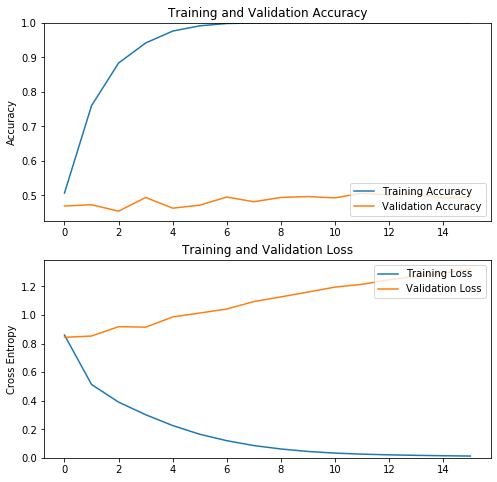

Evaluating model on test set...
Result on test set: 52.22%
Run 2...
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_7 (SimpleRNN)     (None, 128)               144512    
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 258       
Total params: 144,770
Trainable params: 144,770
Non-trainable params: 0
_________________________________________________________________
None
Train on 7231 samples, validate on 804 samples
Epoch 1/100
 - 2s - loss: 0.8596 - acc: 0.5052 - val_loss: 0.8722 - val_acc: 0.4652

Epoch 00001: val_loss improved from inf to 0.87217, saving model to checkpoints/GRAZ_LSTM__run_2.h5
Epoch 2/100
 - 1s - loss: 0.5066 - acc: 0.7634 - val_loss: 0.8966 - val_acc: 0.4664

Epoch 00002: val_loss did not improve from 0.87217
Epoch 3/100
 - 1s - loss: 0.3848 - acc: 0.8762 - val_loss: 0.9405 - 

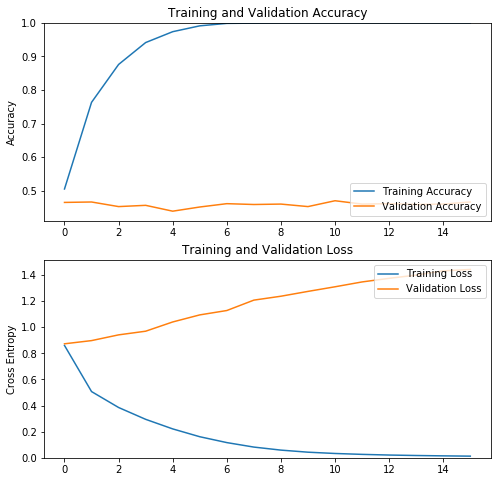

Evaluating model on test set...
Result on test set: 50.82%
Run 3...
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_8 (SimpleRNN)     (None, 128)               144512    
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 258       
Total params: 144,770
Trainable params: 144,770
Non-trainable params: 0
_________________________________________________________________
None
Train on 7231 samples, validate on 804 samples
Epoch 1/100
 - 3s - loss: 0.8748 - acc: 0.5049 - val_loss: 0.8377 - val_acc: 0.5012

Epoch 00001: val_loss improved from inf to 0.83773, saving model to checkpoints/GRAZ_LSTM__run_3.h5
Epoch 2/100
 - 1s - loss: 0.5011 - acc: 0.7693 - val_loss: 0.8528 - val_acc: 0.4813

Epoch 00002: val_loss did not improve from 0.83773
Epoch 3/100
 - 1s - loss: 0.3742 - acc: 0.8862 - val_loss: 0.8772 - 

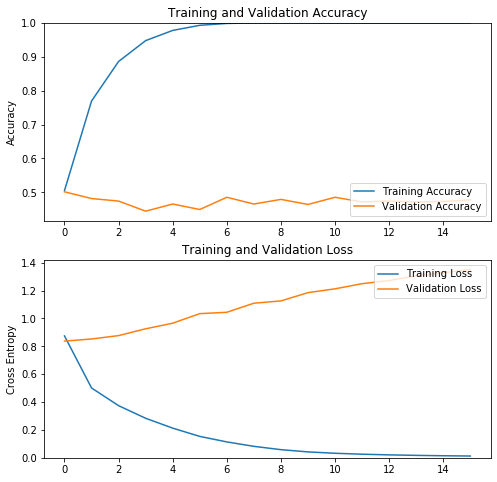

Evaluating model on test set...
Result on test set: 52.26%
Run 4...
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_9 (SimpleRNN)     (None, 128)               144512    
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 258       
Total params: 144,770
Trainable params: 144,770
Non-trainable params: 0
_________________________________________________________________
None
Train on 7231 samples, validate on 804 samples
Epoch 1/100
 - 3s - loss: 0.8596 - acc: 0.5016 - val_loss: 0.8461 - val_acc: 0.4714

Epoch 00001: val_loss improved from inf to 0.84606, saving model to checkpoints/GRAZ_LSTM__run_4.h5
Epoch 2/100
 - 1s - loss: 0.5265 - acc: 0.7482 - val_loss: 0.8409 - val_acc: 0.4540

Epoch 00002: val_loss improved from 0.84606 to 0.84091, saving model to checkpoints/GRAZ_LSTM__run_4.h5
Epoch 3/100
 - 

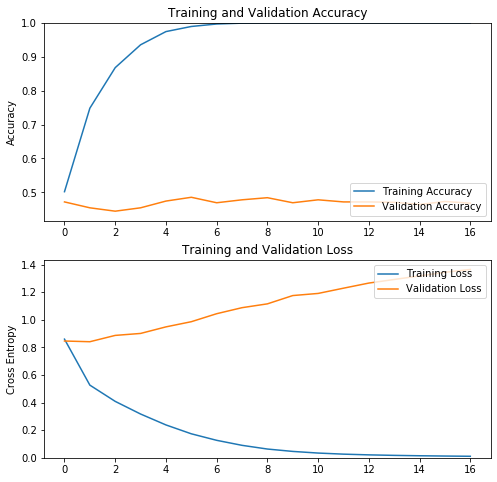

Evaluating model on test set...
Result on test set: 51.17%
Run 5...
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_10 (SimpleRNN)    (None, 128)               144512    
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 258       
Total params: 144,770
Trainable params: 144,770
Non-trainable params: 0
_________________________________________________________________
None
Train on 7232 samples, validate on 804 samples
Epoch 1/100
 - 3s - loss: 0.8658 - acc: 0.5101 - val_loss: 0.8499 - val_acc: 0.4714

Epoch 00001: val_loss improved from inf to 0.84993, saving model to checkpoints/GRAZ_LSTM__run_5.h5
Epoch 2/100
 - 1s - loss: 0.5090 - acc: 0.7627 - val_loss: 0.8585 - val_acc: 0.4602

Epoch 00002: val_loss did not improve from 0.84993
Epoch 3/100
 - 1s - loss: 0.3825 - acc: 0.8818 - val_loss: 0.8887 - 

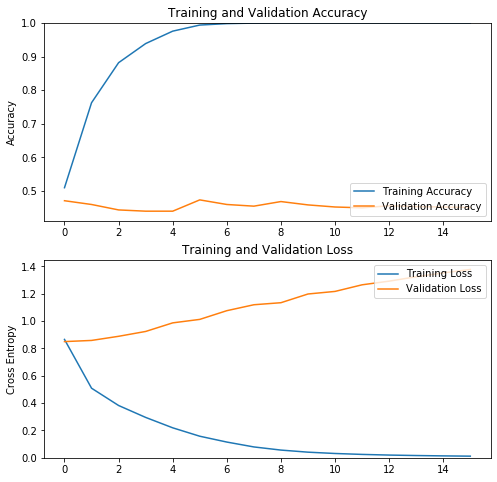

Evaluating model on test set...
Result on test set: 50.40%
51.37% (+/- 0.75%)
Saving CV values to file....
CV values successfully saved!



In [47]:
from sklearn.model_selection import StratifiedKFold
# from models import LSTM
import datetime
from keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping


# define KFOLD-fold cross validation test harness
kfold = StratifiedKFold(n_splits = KFOLD, shuffle = True, random_state = SEED)
cvscores = []
history = []
ii = 1
for train, test in kfold.split(x_subject, y_subject[:, 0]):
    print('Run ' + str(ii) + '...')
    # create callbacks
    model_name_str = 'GRAZ_LSTM_' + \
                     '_run_' + str(ii)

    # initialize and create the model
    model = Vanilla_RNN(model_name_str)
    model.create_model(x_subject.shape[1:], print_summary = True)
    
    # fit model. If you specify monitor=True, then the model will create callbacks
    # and write its state to a HDF5 file
    train_data =  [x_subject[train], y_subject[train]]
    monitor_index = 'val_loss'
    h = run_model(model.model, model_name_str,100, train_data, 0.1, 256, monitor_index)
    save_model(model.model, model_name_str, '')
    draw_graphs(h)
    history.append(h)

    history.append(h)
    # evaluate the model
    print('Evaluating model on test set...')
    scores = model.evaluate(x_subject[test], y_subject[test], verbose = 0)
    print("Result on test set: %.2f%%" % ( scores[1] * 100))
    cvscores.append(scores[1] * 100)
    ii += 1
    
try:
  # print some evaluation statistics and write results to file
  print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
  cv_all_subjects = np.asarray(cvscores)
  print('Saving CV values to file....')
  np.savetxt('GRAZ_CV_' + 'LSTM_' + str(DROPOUT) + 'do'+'.csv', 
              cv_all_subjects, delimiter = ',', fmt = '%2.4f')
  print('CV values successfully saved!\n')
except:
  print ('could not save')